In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/MyDrive/

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6984555572745695455
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1745276110
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13124044553949125552
 physical_device_desc: "device: 0, name: NVIDIA RTX A2000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [4]:
import pandas as pd
#import pandas_profiling
import numpy as np
import cupy as cp
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error

from six import StringIO

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import math
from scipy import stats
import numpy as np
import optuna.integration.lightgbm as lgb
import pandas as pd
import tensorflow as tf

from datetime import datetime
from tensorflow import feature_column
from tensorflow.keras import layers

from xgboost.sklearn import XGBClassifier


print("OK\n")

OK



In [5]:
app_train_origin = pd.read_csv('./home-credit-default-risk/exports/app_train.csv')
app_test_origin =  pd.read_csv('./home-credit-default-risk/exports/app_test.csv')
#bureau_origin = pd.read_csv('./home-credit-default-risk/bureau.csv')
#bureau_balance_origin = pd.read_csv('./home-credit-default-risk/bureau_balance.csv')
pos_cash_balance_origin = pd.read_csv('./home-credit-default-risk/POS_CASH_balance.csv')
#credit_card_balance_origin = pd.read_csv('./home-credit-default-risk/credit_card_balance.csv')
previous_application_origin = pd.read_csv('./home-credit-default-risk/previous_application.csv')
installments_payments_origin = pd.read_csv('./home-credit-default-risk/installments_payments.csv')
# custo data
app_train_hc_only_consumer_origin = pd.read_csv('./home-credit-default-risk/exports/train_hc_only_consumer.csv')
app_test_hc_only_consumer_origin = pd.read_csv('./home-credit-default-risk/exports/test_hc_only_consumer.csv')
app_train_1000_mean_origin = pd.read_csv('./home-credit-default-risk/exports/train_hc_only_consumer_installment_payment_ratio_1000_mean_mean.csv')
app_test_1000_mean_origin = pd.read_csv('./home-credit-default-risk/exports/test_hc_only_consumer_installment_payment_ratio_1000_mean_mean.csv')
app_train_max_installment_ratio_origin = pd.read_csv('./home-credit-default-risk/exports/train_hc_only_consumer_annuity_to_max_installment_ratio.csv')
app_test_max_installment_ratio_origin = pd.read_csv('./home-credit-default-risk/exports/test_hc_only_consumer_annuity_to_max_installment_ratio.csv')
app_train_origin.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_13,FLAG_DOCUMENT_16,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_YEAR,credit_annuity_ratio,credit_goods_price_ratio,credit_downpayment,AGE_INT
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,1,0,0,0,0.0,1.0,16.461104,1.158397,-55597.5,-25.920548
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,1,0,0,0,0.0,0.0,36.234085,1.145199,-164002.5,-45.931507
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,20.000000,1.000000,0.0,-52.180822
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,1,0,0,0,NaN,NaN,10.532818,1.052803,-15682.5,-52.068493
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,23.461618,1.000000,0.0,-54.608219


In [6]:
app_train = app_train_origin.copy()
app_test = app_test_origin.copy()
pos_cash_balance = pos_cash_balance_origin.copy()
previous_application = previous_application_origin.copy()
installments_payments = installments_payments_origin.copy()
app_train_consumer = app_train_hc_only_consumer_origin.copy()
app_test_consumer = app_test_hc_only_consumer_origin.copy()
app_train_1000_mean = app_train_1000_mean_origin.copy()
app_test_1000_mean = app_test_1000_mean_origin.copy()
app_train_max_installment_ratio = app_train_max_installment_ratio_origin.copy()
app_test_max_installment_ratio = app_test_max_installment_ratio_origin.copy()

In [7]:
#app_train = app_train[['SK_ID_CURR','TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
#app_test = app_test[['SK_ID_CURR','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].copy()
app_train = app_train[['SK_ID_CURR','TARGET']].copy()
app_test = app_test[['SK_ID_CURR']].copy()
len(app_test)

48744

### 申し込み月におけるConsumer loanの情報をマージ

In [8]:
app_train_consumer = app_train_consumer.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_test_consumer = app_test_consumer.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_train_consumer.head()

,SK_ID_CURR,consumer_amt_annuity,consumer_amt_application,consumer_amt_credit,consumer_amt_down_payment,consumer_amt_goods_price,consumer_weekday_appr_process_start,consumer_hour_appr_process_start,consumer_flag_last_appl_per_contract,consumer_nflag_last_appl_in_day,...,consumer_cnt_payment,consumer_name_yield_group,consumer_product_combination,consumer_days_first_drawing,consumer_days_first_due,consumer_days_last_due_1st_version,consumer_days_last_due,consumer_days_termination,consumer_nflag_insured_on_approval,consumer_max_sk_dpd
0,100002,9251.775,179055.0,179055.0,0.0,179055,SATURDAY,9,Y,1,...,24,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0,0
1,100006,29027.520,334917.0,267930.0,66987.0,334917,SUNDAY,15,Y,1,...,12,high,POS household with interest,365243.0,-281.0,49.0,365243.0,365243.0,0.0,0
2,100009,10418.670,95841.0,88632.0,14377.0,95841,WEDNESDAY,17,Y,1,...,10,middle,POS household with interest,365243.0,-43.0,227.0,365243.0,365243.0,0.0,0
3,100014,14045.625,73800.0,73800.0,0.0,73800,TUESDAY,14,Y,1,...,6,middle,POS other with interest,365243.0,-64.0,86.0,365243.0,365243.0,0.0,0
4,100017,11783.520,195291.0,198409.5,22500.0,195291,FRIDAY,18,Y,1,...,24,middle,POS household with interest,365243.0,-581.0,109.0,365243.0,365243.0,0.0,0


In [9]:
# trainへマージ
app_train = pd.merge(app_train, app_train_consumer, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_test_consumer, on='SK_ID_CURR', how='left')
len(app_train)

307511

### installment_payment_ratio_1000_mean_meanをマージ

In [10]:
app_train_1000_mean = app_train_1000_mean.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_test_1000_mean = app_test_1000_mean.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_train_1000_mean.head()

,SK_ID_CURR,consumer_installment_payment_ratio_1000_mean_mean
0,100002,0.0
1,100003,0.0
2,100006,0.0
3,100008,0.0
4,100009,0.0


In [11]:
# trainへマージ
app_train = pd.merge(app_train, app_train_1000_mean, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_test_1000_mean, on='SK_ID_CURR', how='left')
len(app_train)

307511

### annuity_to_max_installment_ratioをマージ

In [12]:
app_train_max_installment_ratio = app_train_max_installment_ratio.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_test_max_installment_ratio = app_test_max_installment_ratio.rename(columns={'sk_id_curr': 'SK_ID_CURR'})
app_test_max_installment_ratio.head()

,SK_ID_CURR,consumer_annuity_to_max_installment_ratio
0,100067,-667.1250
1,100107,-1205.0000
2,100172,-493.3600
3,100184,-448.2917
4,100222,-831.0732


In [13]:
# trainへマージ
app_train = pd.merge(app_train, app_train_max_installment_ratio, on='SK_ID_CURR', how='left')
# testへマージ
app_test = pd.merge(app_test, app_test_max_installment_ratio, on='SK_ID_CURR', how='left')
len(app_train)

307511

In [14]:
### consumer_amt_annuity

In [15]:
app_train[['consumer_amt_annuity', 'TARGET']].corr()

,consumer_amt_annuity,TARGET
consumer_amt_annuity,1.000000,-0.054247
TARGET,-0.054247,1.000000


In [16]:
### consumer_amt_application

In [17]:
app_train[['consumer_amt_annuity', 'TARGET']].corr()

,consumer_amt_annuity,TARGET
consumer_amt_annuity,1.000000,-0.054247
TARGET,-0.054247,1.000000


In [18]:
### consumer_amt_credit

In [19]:
app_train[['consumer_amt_credit', 'TARGET']].corr()

,consumer_amt_credit,TARGET
consumer_amt_credit,1.000000,-0.032825
TARGET,-0.032825,1.000000


In [20]:
### consumer_amt_down_payment

In [21]:
app_train[['consumer_amt_down_payment', 'TARGET']].corr()

,consumer_amt_down_payment,TARGET
consumer_amt_down_payment,1.000000,-0.017728
TARGET,-0.017728,1.000000


In [22]:
app_train.drop(['consumer_amt_down_payment'], axis=1, inplace=True)
app_test.drop(['consumer_amt_down_payment'], axis=1, inplace=True)

In [23]:
### consumer_amt_goods_price

In [24]:
app_train[['consumer_amt_goods_price', 'TARGET']].corr()

,consumer_amt_goods_price,TARGET
consumer_amt_goods_price,1.000000,-0.036496
TARGET,-0.036496,1.000000


In [25]:
### consumer_weekday_appr_process_start

In [26]:
replace_columns = app_train['consumer_weekday_appr_process_start'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_weekday_appr_process_start'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_weekday_appr_process_start'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_weekday_appr_process_start'].value_counts()

0.0    5220
1.0    4528
3.0    4084
4.0    4067
6.0    4008
5.0    4005
2.0    3961
Name: consumer_weekday_appr_process_start, dtype: int64

In [27]:
app_train[['consumer_weekday_appr_process_start', 'TARGET']].corr()

,consumer_weekday_appr_process_start,TARGET
consumer_weekday_appr_process_start,1.00000,0.02323
TARGET,0.02323,1.00000


In [28]:
### consumer_hour_appr_process_start

In [29]:
app_train[['consumer_hour_appr_process_start', 'TARGET']].corr()

,consumer_hour_appr_process_start,TARGET
consumer_hour_appr_process_start,1.000000,-0.028247
TARGET,-0.028247,1.000000


In [30]:
### consumer_flag_last_appl_per_contract

In [31]:
replace_columns = app_train['consumer_flag_last_appl_per_contract'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_flag_last_appl_per_contract'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_flag_last_appl_per_contract'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_flag_last_appl_per_contract'].value_counts()

0.0    29873
Name: consumer_flag_last_appl_per_contract, dtype: int64

In [32]:
app_train[['consumer_flag_last_appl_per_contract', 'TARGET']].corr()

,consumer_flag_last_appl_per_contract,TARGET
consumer_flag_last_appl_per_contract,NaN,NaN
TARGET,NaN,1.0


In [33]:
app_train.drop(['consumer_flag_last_appl_per_contract'], axis=1, inplace=True)
app_test.drop(['consumer_flag_last_appl_per_contract'], axis=1, inplace=True)

In [34]:
### consumer_nflag_last_appl_in_day

In [35]:
app_train[['consumer_nflag_last_appl_in_day', 'TARGET']].corr()

,consumer_nflag_last_appl_in_day,TARGET
consumer_nflag_last_appl_in_day,1.00000,0.00468
TARGET,0.00468,1.00000


In [36]:
app_train.drop(['consumer_nflag_last_appl_in_day'], axis=1, inplace=True)
app_test.drop(['consumer_nflag_last_appl_in_day'], axis=1, inplace=True)

In [37]:
### consumer_rate_down_payment

In [38]:
app_train[['consumer_rate_down_payment', 'TARGET']].corr()

,consumer_rate_down_payment,TARGET
consumer_rate_down_payment,1.000000,-0.017429
TARGET,-0.017429,1.000000


In [39]:
app_train.drop(['consumer_rate_down_payment'], axis=1, inplace=True)
app_test.drop(['consumer_rate_down_payment'], axis=1, inplace=True)

In [40]:
### consumer_rate_interest_primary

In [41]:
app_train[['consumer_rate_interest_primary', 'TARGET']].corr()

,consumer_rate_interest_primary,TARGET
consumer_rate_interest_primary,1.000000,0.011642
TARGET,0.011642,1.000000


In [42]:
app_train.drop(['consumer_rate_interest_primary'], axis=1, inplace=True)
app_test.drop(['consumer_rate_interest_primary'], axis=1, inplace=True)

In [43]:
### consumer_rate_interest_privileged

In [44]:
app_train[['consumer_rate_interest_privileged', 'TARGET']].corr()

,consumer_rate_interest_privileged,TARGET
consumer_rate_interest_privileged,1.000000,0.011976
TARGET,0.011976,1.000000


In [45]:
app_train.drop(['consumer_rate_interest_privileged'], axis=1, inplace=True)
app_test.drop(['consumer_rate_interest_privileged'], axis=1, inplace=True)

In [46]:
### consumer_name_cash_loan_purpose

In [47]:
app_train['consumer_name_cash_loan_purpose'].value_counts()

XAP    29873
Name: consumer_name_cash_loan_purpose, dtype: int64

In [48]:
app_train.drop(['consumer_name_cash_loan_purpose'], axis=1, inplace=True)
app_test.drop(['consumer_name_cash_loan_purpose'], axis=1, inplace=True)

In [49]:
### consumer_name_contract_status

In [50]:
app_train['consumer_name_contract_status'].value_counts()

Approved    29873
Name: consumer_name_contract_status, dtype: int64

In [51]:
app_train.drop(['consumer_name_contract_status'], axis=1, inplace=True)
app_test.drop(['consumer_name_contract_status'], axis=1, inplace=True)

In [52]:
### consumer_days_decision

In [53]:
app_train['consumer_days_decision'].value_counts()

-133.0     116
-126.0     104
-316.0     103
-161.0     102
-308.0     101
          ... 
-1502.0      1
-1862.0      1
-1425.0      1
-802.0       1
-2202.0      1
Name: consumer_days_decision, Length: 1162, dtype: int64

In [54]:
app_train[['consumer_days_decision', 'TARGET']].corr()

,consumer_days_decision,TARGET
consumer_days_decision,1.000000,0.001393
TARGET,0.001393,1.000000


In [55]:
app_train.drop(['consumer_days_decision'], axis=1, inplace=True)
app_test.drop(['consumer_days_decision'], axis=1, inplace=True)

In [56]:
### consumer_name_payment_type

In [57]:
app_train['consumer_name_payment_type'].value_counts()

Cash through the bank                        25852
XNA                                           3814
Non-cash from your account                     191
Cashless from the account of the employer       16
Name: consumer_name_payment_type, dtype: int64

In [58]:
replace_columns = app_train['consumer_name_payment_type'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_name_payment_type'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_name_payment_type'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_name_payment_type'].value_counts()

1.0    25852
0.0     3814
2.0      191
3.0       16
Name: consumer_name_payment_type, dtype: int64

In [59]:
app_train[['consumer_name_payment_type', 'TARGET']].corr()

,consumer_name_payment_type,TARGET
consumer_name_payment_type,1.000000,-0.011017
TARGET,-0.011017,1.000000


In [60]:
app_train.drop(['consumer_name_payment_type'], axis=1, inplace=True)
app_test.drop(['consumer_name_payment_type'], axis=1, inplace=True)

In [61]:
### consumer_code_reject_reason

In [62]:
app_train['consumer_code_reject_reason'].value_counts()

XAP    29873
Name: consumer_code_reject_reason, dtype: int64

In [63]:
app_train.drop(['consumer_code_reject_reason'], axis=1, inplace=True)
app_test.drop(['consumer_code_reject_reason'], axis=1, inplace=True)

In [64]:
### consumer_name_type_suite

In [65]:
app_train['consumer_name_type_suite'].value_counts()

Unaccompanied      9141
Family             5624
Spouse, partner    1408
Children            458
Other_B             346
Other_A             171
Group of people      44
Name: consumer_name_type_suite, dtype: int64

In [66]:
replace_columns = app_train['consumer_name_type_suite'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_name_type_suite'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_name_type_suite'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_name_type_suite'].value_counts()

2.0    9141
0.0    5624
1.0    1408
3.0     458
4.0     346
5.0     171
6.0      44
Name: consumer_name_type_suite, dtype: int64

In [67]:
app_train[['consumer_name_type_suite', 'TARGET']].corr()

,consumer_name_type_suite,TARGET
consumer_name_type_suite,1.000000,0.014575
TARGET,0.014575,1.000000


In [68]:
app_train.drop(['consumer_name_type_suite'], axis=1, inplace=True)
app_test.drop(['consumer_name_type_suite'], axis=1, inplace=True)

In [69]:
### consumer_name_client_type

In [70]:
app_train['consumer_name_client_type'].value_counts()

Repeater     18901
New           7231
Refreshed     3638
XNA            103
Name: consumer_name_client_type, dtype: int64

In [71]:
replace_columns = app_train['consumer_name_client_type'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_name_client_type'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_name_client_type'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_name_client_type'].value_counts()

1.0    18901
0.0     7231
2.0     3638
3.0      103
Name: consumer_name_client_type, dtype: int64

In [72]:
app_train[['consumer_name_client_type', 'TARGET']].corr()

,consumer_name_client_type,TARGET
consumer_name_client_type,1.00000,-0.05542
TARGET,-0.05542,1.00000


In [73]:
### consumer_name_goods_category

In [74]:
app_train['consumer_name_goods_category'].value_counts()

Mobile                      5838
Consumer Electronics        5399
Computers                   4856
Audio/Video                 4337
Furniture                   2750
Clothing and Accessories    1680
Construction Materials      1379
Jewelry                      633
Homewares                    513
Auto Accessories             462
Photo / Cinema Equipment     441
Medical Supplies             440
Vehicles                     298
Medicine                     168
Sport and Leisure            167
Gardening                    162
Tourism                      128
Direct Sales                  89
Office Appliances             79
Fitness                       20
XNA                           16
Education                      9
Insurance                      3
Weapon                         3
Other                          2
Additional Service             1
Name: consumer_name_goods_category, dtype: int64

In [75]:
replace_columns = app_train['consumer_name_goods_category'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_name_goods_category'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_name_goods_category'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_name_goods_category'].value_counts()

3.0     5838
2.0     5399
5.0     4856
1.0     4337
11.0    2750
12.0    1680
9.0     1379
10.0     633
6.0      513
13.0     462
15.0     441
4.0      440
0.0      298
17.0     168
14.0     167
16.0     162
8.0      128
18.0      89
7.0       79
21.0      20
19.0      16
20.0       9
22.0       3
24.0       3
23.0       2
25.0       1
Name: consumer_name_goods_category, dtype: int64

In [76]:
app_train[['consumer_name_goods_category', 'TARGET']].corr()

,consumer_name_goods_category,TARGET
consumer_name_goods_category,1.000000,-0.034201
TARGET,-0.034201,1.000000


In [77]:
### consumer_name_portfolio

In [78]:
app_train['consumer_name_portfolio'].value_counts()

POS     29869
Cars        4
Name: consumer_name_portfolio, dtype: int64

In [79]:
replace_columns = app_train['consumer_name_portfolio'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_name_portfolio'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_name_portfolio'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_name_portfolio'].value_counts()

0.0    29869
1.0        4
Name: consumer_name_portfolio, dtype: int64

In [80]:
app_train[['consumer_name_portfolio', 'TARGET']].corr()

,consumer_name_portfolio,TARGET
consumer_name_portfolio,1.000000,0.006811
TARGET,0.006811,1.000000


In [81]:
app_train.drop(['consumer_name_portfolio'], axis=1, inplace=True)
app_test.drop(['consumer_name_portfolio'], axis=1, inplace=True)

In [82]:
### consumer_name_product_type

In [83]:
app_train['consumer_name_product_type'].value_counts()

XNA    29873
Name: consumer_name_product_type, dtype: int64

In [84]:
app_train.drop(['consumer_name_product_type'], axis=1, inplace=True)
app_test.drop(['consumer_name_product_type'], axis=1, inplace=True)

In [85]:
### consumer_channel_type

In [86]:
app_train['consumer_channel_type'].value_counts()

Country-wide        16189
Stone                8149
Regional / Local     5531
Car dealer              4
Name: consumer_channel_type, dtype: int64

In [87]:
replace_columns = app_train['consumer_channel_type'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_channel_type'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_channel_type'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_channel_type'].value_counts()

1.0    16189
0.0     8149
2.0     5531
3.0        4
Name: consumer_channel_type, dtype: int64

In [88]:
app_train[['consumer_channel_type', 'TARGET']].corr()

,consumer_channel_type,TARGET
consumer_channel_type,1.000000,0.009283
TARGET,0.009283,1.000000


In [89]:
app_train.drop(['consumer_channel_type'], axis=1, inplace=True)
app_test.drop(['consumer_channel_type'], axis=1, inplace=True)

In [90]:
### consumer_sellerplace_area

In [91]:
app_train['consumer_sellerplace_area'].value_counts()

100.0     2083
50.0      1940
30.0      1327
20.0      1243
40.0       998
          ... 
2510.0       1
526.0        1
632.0        1
654.0        1
970.0        1
Name: consumer_sellerplace_area, Length: 910, dtype: int64

In [92]:
app_train[['consumer_sellerplace_area', 'TARGET']].corr()

,consumer_sellerplace_area,TARGET
consumer_sellerplace_area,1.000000,-0.000576
TARGET,-0.000576,1.000000


In [93]:
app_train.drop(['consumer_sellerplace_area'], axis=1, inplace=True)
app_test.drop(['consumer_sellerplace_area'], axis=1, inplace=True)

In [94]:
### consumer_name_seller_industry

In [95]:
app_train['consumer_name_seller_industry'].value_counts()

Consumer electronics    14838
Connectivity             6390
Furniture                2880
Construction             1736
Clothing                 1658
Industry                  818
Auto technology           643
Jewelry                   507
MLM partners              190
XNA                       122
Tourism                    91
Name: consumer_name_seller_industry, dtype: int64

In [96]:
replace_columns = app_train['consumer_name_seller_industry'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_name_seller_industry'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_name_seller_industry'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_name_seller_industry'].value_counts()

1.0     14838
4.0      6390
7.0      2880
3.0      1736
8.0      1658
2.0       818
0.0       643
6.0       507
9.0       190
10.0      122
5.0        91
Name: consumer_name_seller_industry, dtype: int64

In [97]:
app_train[['consumer_name_seller_industry', 'TARGET']].corr()

,consumer_name_seller_industry,TARGET
consumer_name_seller_industry,1.000000,-0.020888
TARGET,-0.020888,1.000000


In [98]:
### consumer_cnt_payment

In [99]:
app_train['consumer_cnt_payment'].value_counts()

12.0    10472
24.0     6007
10.0     4762
6.0      4000
18.0     2010
36.0      808
8.0       704
4.0       405
16.0      273
14.0      169
30.0      161
20.0       73
9.0         6
5.0         5
7.0         3
48.0        3
22.0        2
13.0        2
23.0        2
3.0         1
72.0        1
35.0        1
11.0        1
60.0        1
29.0        1
Name: consumer_cnt_payment, dtype: int64

In [100]:
app_train[['consumer_cnt_payment', 'TARGET']].corr()

,consumer_cnt_payment,TARGET
consumer_cnt_payment,1.00000,0.01656
TARGET,0.01656,1.00000


In [101]:
app_train.drop(['consumer_cnt_payment'], axis=1, inplace=True)
app_test.drop(['consumer_cnt_payment'], axis=1, inplace=True)

In [102]:
### consumer_name_yield_group

In [103]:
app_train['consumer_name_yield_group'].value_counts()

middle        10286
low_normal    10181
low_action     6018
high           3388
Name: consumer_name_yield_group, dtype: int64

In [104]:
replace_columns = app_train['consumer_name_yield_group'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_name_yield_group'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_name_yield_group'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_name_yield_group'].value_counts()

2.0    10286
0.0    10181
3.0     6018
1.0     3388
Name: consumer_name_yield_group, dtype: int64

In [105]:
app_train[['consumer_name_yield_group', 'TARGET']].corr()

,consumer_name_yield_group,TARGET
consumer_name_yield_group,1.000000,-0.002245
TARGET,-0.002245,1.000000


In [106]:
app_train.drop(['consumer_name_yield_group'], axis=1, inplace=True)
app_test.drop(['consumer_name_yield_group'], axis=1, inplace=True)

In [107]:
### consumer_product_combination

In [108]:
app_train['consumer_product_combination'].value_counts()

POS household with interest       9826
POS industry with interest        5568
POS household without interest    4875
POS mobile with interest          4813
POS mobile without interest       1780
POS other with interest           1756
POS industry without interest      919
POS others without interest        336
Name: consumer_product_combination, dtype: int64

In [109]:
replace_columns = app_train['consumer_product_combination'].unique().tolist()
replace_columns = ['xxxx' if e == "NaN" or type(e) is float and math.isnan(e) else e for e in replace_columns]
replace_columns.remove('xxxx')
replace_value = [x for x in range(len(replace_columns))]
app_train['consumer_product_combination'].replace(replace_columns, replace_value, inplace=True)
app_test['consumer_product_combination'].replace(replace_columns, replace_value, inplace=True)
app_train['consumer_product_combination'].value_counts()

1.0    9826
4.0    5568
3.0    4875
6.0    4813
5.0    1780
0.0    1756
7.0     919
2.0     336
Name: consumer_product_combination, dtype: int64

In [110]:
app_train[['consumer_product_combination', 'TARGET']].corr()

,consumer_product_combination,TARGET
consumer_product_combination,1.000000,0.003334
TARGET,0.003334,1.000000


In [111]:
app_train.drop(['consumer_product_combination'], axis=1, inplace=True)
app_test.drop(['consumer_product_combination'], axis=1, inplace=True)

In [112]:
### consumer_days_first_drawing

In [113]:
app_train['consumer_days_first_drawing'].value_counts()

365243.0    29854
Name: consumer_days_first_drawing, dtype: int64

In [114]:
app_train.drop(['consumer_days_first_drawing'], axis=1, inplace=True)
app_test.drop(['consumer_days_first_drawing'], axis=1, inplace=True)

In [115]:
### consumer_days_first_due

In [116]:
app_train['consumer_days_first_due'].value_counts()

-103.0     120
-124.0     114
-94.0      111
-277.0     109
-250.0     107
          ... 
-787.0       1
-2619.0      1
-1588.0      1
-1295.0      1
-2470.0      1
Name: consumer_days_first_due, Length: 1131, dtype: int64

In [117]:
#app_train['consumer_days_first_due'] = pd.cut(app_train['consumer_days_first_due'], bins=100, labels=False)
#app_test['consumer_days_first_due'] =  pd.cut(app_test['consumer_days_first_due'], bins=100, labels=False)

In [118]:
#%matplotlib inline
#sns.countplot(x='consumer_days_first_due', hue='TARGET', data=app_train)
#plt.legend(loc='upper right', title='TARGET')
#plt.show()

In [119]:
app_train[['consumer_days_first_due', 'TARGET']].corr()

,consumer_days_first_due,TARGET
consumer_days_first_due,1.0000,-0.0052
TARGET,-0.0052,1.0000


In [120]:
app_train.drop(['consumer_days_first_due'], axis=1, inplace=True)
app_test.drop(['consumer_days_first_due'], axis=1, inplace=True)

In [121]:
### consumer_days_last_due_1st_version

In [122]:
app_train['consumer_days_last_due_1st_version'].value_counts()

 26.0      152
 22.0      141
-8.0       135
-6.0       133
-10.0      132
          ... 
 781.0       1
-2349.0      1
-1318.0      1
-785.0       1
 905.0       1
Name: consumer_days_last_due_1st_version, Length: 1246, dtype: int64

In [123]:
app_train[['consumer_days_last_due_1st_version', 'TARGET']].corr()

,consumer_days_last_due_1st_version,TARGET
consumer_days_last_due_1st_version,1.000000,0.015037
TARGET,0.015037,1.000000


In [124]:
app_train.drop(['consumer_days_last_due_1st_version'], axis=1, inplace=True)
app_test.drop(['consumer_days_last_due_1st_version'], axis=1, inplace=True)

In [125]:
### consumer_days_last_due

In [126]:
app_train['consumer_days_last_due'].value_counts()

 365243.0    23147
-9.0           225
-10.0          222
-8.0           222
-7.0           217
             ...  
-2197.0          1
-209.0           1
-2238.0          1
-1600.0          1
-2019.0          1
Name: consumer_days_last_due, Length: 373, dtype: int64

In [127]:
app_train[['consumer_days_last_due', 'TARGET']].corr()

,consumer_days_last_due,TARGET
consumer_days_last_due,1.000000,0.020346
TARGET,0.020346,1.000000


In [128]:
### consumer_days_termination

In [129]:
app_train['consumer_days_termination'].value_counts()

 365243.0    24327
-4.0           247
-9.0           239
-3.0           234
-2.0           228
             ...  
-1696.0          1
-1511.0          1
-1724.0          1
-1507.0          1
-167.0           1
Name: consumer_days_termination, Length: 192, dtype: int64

In [130]:
app_train[['consumer_days_termination', 'TARGET']].corr()

,consumer_days_termination,TARGET
consumer_days_termination,1.00000,0.01638
TARGET,0.01638,1.00000


In [131]:
app_train.drop(['consumer_days_termination'], axis=1, inplace=True)
app_test.drop(['consumer_days_termination'], axis=1, inplace=True)

In [132]:
### consumer_nflag_insured_on_approval

In [133]:
app_train['consumer_nflag_insured_on_approval'].value_counts()

0.0    22443
1.0     7411
Name: consumer_nflag_insured_on_approval, dtype: int64

In [134]:
app_train[['consumer_nflag_insured_on_approval', 'TARGET']].corr()

,consumer_nflag_insured_on_approval,TARGET
consumer_nflag_insured_on_approval,1.000000,0.011647
TARGET,0.011647,1.000000


In [135]:
app_train.drop(['consumer_nflag_insured_on_approval'], axis=1, inplace=True)
app_test.drop(['consumer_nflag_insured_on_approval'], axis=1, inplace=True)

In [136]:
### consumer_max_sk_dpd

In [137]:
app_train['consumer_max_sk_dpd'].value_counts()

0.0       29480
1.0          51
2.0          45
3.0          31
5.0          27
          ...  
1488.0        1
31.0          1
2110.0        1
2115.0        1
27.0          1
Name: consumer_max_sk_dpd, Length: 172, dtype: int64

In [138]:
app_train['consumer_max_sk_dpd'] = pd.cut(app_train['consumer_max_sk_dpd'], bins=5, labels=False)
app_test['consumer_max_sk_dpd'] =  pd.cut(app_test['consumer_max_sk_dpd'], bins=5, labels=False)

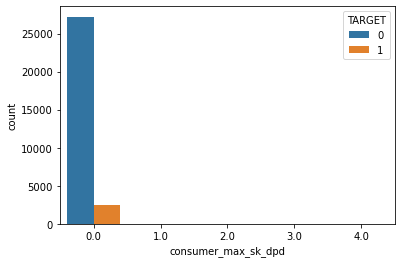

In [139]:
%matplotlib inline
sns.countplot(x='consumer_max_sk_dpd', hue='TARGET', data=app_train)
plt.legend(loc='upper right', title='TARGET')
plt.show()

In [140]:
app_train[['consumer_max_sk_dpd', 'TARGET']].corr()

,consumer_max_sk_dpd,TARGET
consumer_max_sk_dpd,1.000000,-0.003964
TARGET,-0.003964,1.000000


In [141]:
app_train.drop(['consumer_max_sk_dpd'], axis=1, inplace=True)
app_test.drop(['consumer_max_sk_dpd'], axis=1, inplace=True)

In [142]:
### consumer_installment_payment_ratio_1000_mean_mean

In [143]:
app_train[['consumer_installment_payment_ratio_1000_mean_mean', 'TARGET']].corr()

,consumer_installment_payment_ratio_1000_mean_mean,TARGET
consumer_installment_payment_ratio_1000_mean_mean,1.000000,-0.035753
TARGET,-0.035753,1.000000


In [144]:
### consumer_annuity_to_max_installment_ratio

In [145]:
app_train[['consumer_annuity_to_max_installment_ratio', 'TARGET']].corr()

,consumer_annuity_to_max_installment_ratio,TARGET
consumer_annuity_to_max_installment_ratio,1.000000,0.009288
TARGET,0.009288,1.000000


In [146]:
app_train.drop(['consumer_annuity_to_max_installment_ratio'], axis=1, inplace=True)
app_test.drop(['consumer_annuity_to_max_installment_ratio'], axis=1, inplace=True)

In [147]:
### train
app_train.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_only_consumer_train.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [148]:
### test
app_test.to_csv(
    path_or_buf="./home-credit-default-risk/exports/hc_only_consumer_test.csv", # 出力先
    sep=",",                                            # 区切り文字
    index=False,                                        # indexの出力有無
    header=True                                        # headerの出力有無
)

In [149]:
#num_cols = ['max_credit_day_overdue', 'max_days_credit_enddate', 'min_days_enddate_fact', 'max_amt_credit_max_overdue', 'cnt_credit_prolong_in_6month', 'sum_amt_credit_sum', 'sum_amt_credit_sum_debt', 'sum_amt_credit_sum_limit', 'sum_amt_credit_sum_overdue', 'avg_amt_annuity']

data = pd.concat([app_train, app_test], sort=False)
train = data[:len(app_train)]
test = data[len(app_test):]


y_train = train['TARGET']
X_train = app_train.copy().drop('TARGET', axis=1)
X_test = app_test.copy()

# 学習データに基づいてYao-Johnson変換を定義
#pt = PowerTransformer(method = 'yeo-johnson')
#pt.fit(X_train[num_cols])

# 変換後のデータで各列を置換
#X_train[num_cols] = pt.transform(X_train[num_cols])
#X_test[num_cols] = pt.transform(X_test[num_cols])

X_train.head()

,SK_ID_CURR,consumer_amt_annuity,consumer_amt_application,consumer_amt_credit,consumer_amt_goods_price,consumer_weekday_appr_process_start,consumer_hour_appr_process_start,consumer_name_client_type,consumer_name_goods_category,consumer_name_seller_industry,consumer_days_last_due,consumer_installment_payment_ratio_1000_mean_mean
0,100002,9251.775,179055.0,179055.0,179055.0,0.0,9.0,0.0,0.0,0.0,-25.0,0.0
1,100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,29027.520,334917.0,267930.0,334917.0,1.0,15.0,1.0,1.0,1.0,365243.0,0.0
4,100007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
import xgboost as xgb
from sklearn.metrics import log_loss

y_preds = []
models = []
scores = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)


params = {
    'booster': 'gbtree'
    ,'objective': 'binary:logistic'
    ,'silent': 1
    ,'random_state': 17
    ,'gpu_id': 0
    ,'tree_method': 'gpu_hist'
    ,'eval_metric': 'auc'
    ,'eta': 0.1
    #,'max_round': 100
    ,'max_depth': 8
    ,'subsample': 0.8
    ,'colsample_state': 71
    ,'colsample_bytree': 1.0
    ,'colsample_bylevel': 0.3
    ,'subsumple': 0.9
    ,'gamma': 0
    ,'lambda': 1
    ,'alpha': 0
    ,'min_child_weight': 1
}

num_round = 50

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_round, evals=watchlist)
    
    va_pred = model.predict(dvalid)
    score = log_loss(y_val, va_pred)
    oof_train[valid_index] = va_pred
    
    y_pred = model.predict(dtest) 
    
    
    #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    #y_pred = model.predict(X_test, num_iteration=model.best_iteration)##

    y_preds.append(y_pred)
    models.append(model)
    scores.append(score)

[19:38:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_state", "silent", "subsumple" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.53939	eval-auc:0.53624
[1]	train-auc:0.54468	eval-auc:0.54216
[2]	train-auc:0.54530	eval-auc:0.54173
[3]	train-auc:0.54629	eval-auc:0.54257
[4]	train-auc:0.54743	eval-auc:0.54315
[5]	train-auc:0.54719	eval-auc:0.54347
[6]	train-auc:0.55161	eval-auc:0.54314
[7]	train-auc:0.55484	eval-auc:0.54178
[8]	train-auc:0.55575	eval-auc:0.54153
[9]	train-auc:0.55640	eval-auc:0.54198
[10]	train-auc:0.55642	eval-auc:0.54313
[11]	train-auc:0.55785	eval-auc:0.54264
[12]	train-auc:0.55826	eval-auc:0.54209
[13]	train-auc:0.55870	eval-auc:0.54322
[14

[11]	train-auc:0.55856	eval-auc:0.53923
[12]	train-auc:0.55870	eval-auc:0.53980
[13]	train-auc:0.55924	eval-auc:0.54015
[14]	train-auc:0.56009	eval-auc:0.53978
[15]	train-auc:0.56028	eval-auc:0.54018
[16]	train-auc:0.56135	eval-auc:0.53974
[17]	train-auc:0.56149	eval-auc:0.53922
[18]	train-auc:0.56232	eval-auc:0.53959
[19]	train-auc:0.56464	eval-auc:0.53880
[20]	train-auc:0.56519	eval-auc:0.53836
[21]	train-auc:0.56532	eval-auc:0.53918
[22]	train-auc:0.56557	eval-auc:0.53896
[23]	train-auc:0.56625	eval-auc:0.53930
[24]	train-auc:0.56728	eval-auc:0.54010
[25]	train-auc:0.56836	eval-auc:0.54037
[26]	train-auc:0.56846	eval-auc:0.53979
[27]	train-auc:0.56921	eval-auc:0.53892
[28]	train-auc:0.57010	eval-auc:0.53893
[29]	train-auc:0.57066	eval-auc:0.53881
[30]	train-auc:0.57177	eval-auc:0.53792
[31]	train-auc:0.57193	eval-auc:0.53826
[32]	train-auc:0.57228	eval-auc:0.53860
[33]	train-auc:0.57287	eval-auc:0.53899
[34]	train-auc:0.57359	eval-auc:0.53807
[35]	train-auc:0.57470	eval-auc:0.53739
